[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 61.87714338302612
bear 95.37394642829895


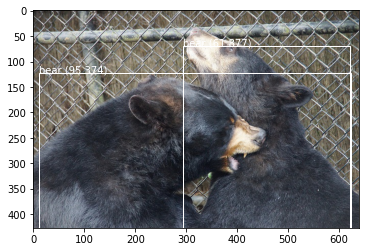

In [25]:
# -*- coding: utf-8 -*-
"""Image_Prediction.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1TsraIkAUJcp-Ae28iIr-IhK_XGTXg4XU
"""

import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

class BoundBox:
	def __init__(self, x1, y1, x2, y2, obj = None, c1 = None):
		self.x1 = x1
		self.y1 = y1
		self.x2 = x2
		self.y2 = y2
		self.obj = obj
		self.c1 = c1
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.c1)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.c1[self.get_label()]
 
		return self.score

def act_function(x):
	return 1. / (1. + np.exp(-x))
 
def decrypt_output(output, a, obj_thresh, net_h, net_w):
	g_height, g_width = output.shape[:2]
	nb_box = 3
	output = output.reshape((g_height, g_width, nb_box, -1))
	nb_class = output.shape[-1] - 5
	boxes = []
	output[..., :2]  = act_function(output[..., :2])
	output[..., 4:]  = act_function(output[..., 4:])
	output[..., 5:]  = output[..., 4][..., np.newaxis] * output[..., 5:]
	output[..., 5:] *= output[..., 5:] > obj_thresh
 
	for i in range(g_height*g_width):
		row = i / g_width
		col = i % g_width
		for b in range(nb_box):
			
			object_1 = output[int(row)][int(col)][b][4]
			if(object_1.all() <= obj_thresh): continue
			
			x, y, w, h = output[int(row)][int(col)][b][:4]
			x = (col + x) / g_width 
			y = (row + y) / g_height 
			w = a[2 * b + 0] * np.exp(w) / net_w 
			h = a[2 * b + 1] * np.exp(h) / net_h 
			
			c1 = output[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, object_1, c1)
			boxes.append(box)
	return boxes

def fix_box(boxes, iheight, iwidth, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].x1 = int((boxes[i].x1 - x_offset) / x_scale * iwidth)
		boxes[i].x2 = int((boxes[i].x2 - x_offset) / x_scale * iwidth)
		boxes[i].y1 = int((boxes[i].y1 - y_offset) / y_scale * iheight)
		boxes[i].y2 = int((boxes[i].y2 - y_offset) / y_scale * iheight)

def overlap(a_i, b_i):
	x1, x2 = a_i
	x3, x4 = b_i
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

def bbox_iou(box1, box2):
	intersect_w = overlap([box1.x1, box1.x2], [box2.x1, box2.x2])
	intersect_h = overlap([box1.y1, box1.y2], [box2.y1, box2.y2])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.x2-box1.x1, box1.y2-box1.y1
	w2, h2 = box2.x2-box2.x1, box2.y2-box2.y1
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].c1)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.c1[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].c1[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].c1[c] = 0

def load_image_pixels(name, shape):
	
	image = load_img(name)
	width, height = image.size
	
	image = load_img(name, target_size=shape)
	
	image = img_to_array(image)
	
	image = image.astype('float32')
	image /= 255.0
	
	image = expand_dims(image, 0)
	return image, width, height

def get_boxes(boxes, labels, thresh):
	box_value, label_value, score_value = list(), list(), list()
	
	for box in boxes:
		
		for i in range(len(labels)):
			
			if box.c1[i] > thresh:
				box_value.append(box)
				label_value.append(labels[i])
				score_value.append(box.c1[i]*100)
				
	return box_value, label_value, score_value

def make_box(name, box_value, label_value, score_value):
	
	data = pyplot.imread(name)
	
	pyplot.imshow(data)
	
	ax = pyplot.gca()
	
	for i in range(len(box_value)):
		box = box_value[i]
		
		y1, x1, y2, x2 = box.y1, box.x1, box.y2, box.x2
		
		width, height = x2 - x1, y2 - y1
		
		makerect = Rectangle((x1, y1), width, height, fill=False, color='white')
		
		ax.add_patch(makerect)
		
		label = "%s (%.3f)" % (label_value[i], score_value[i])
		pyplot.text(x1, y1, label, color='white')
	
	pyplot.show()

animal_model = load_model('/content/drive/MyDrive/animal.h5', compile=False)

width, height = 416, 416

photo_name = '/content/drive/MyDrive/bear_161.jpg'

image, iwidth, iheight = load_image_pixels(photo_name, (width, height))

yhat = animal_model.predict(image)

print([a.shape for a in yhat])

a = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	
	boxes += decrypt_output(yhat[i][0], a[i], class_threshold, height, width)

fix_box(boxes, iheight, iwidth, height, width)

do_nms(boxes, 0.5)

labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe"]

box_value, label_value, score_value = get_boxes(boxes, labels, class_threshold)

for i in range(len(box_value)):
	print(label_value[i], score_value[i])

make_box(photo_name, box_value, label_value, score_value)

